# Emotion Recognition using CNN

Importing libraries

In [2]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

loading dataset

In [3]:
data = pd.read_csv("features.csv")

In [4]:
data.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,labels
0,-655.344543,86.649872,-12.361261,28.343273,-0.276913,9.111378,-10.830962,-0.023427,-17.030333,-3.272646,...,-5.887830,4.827703,-7.893806,3.420066,-1.663579,-3.320957,-4.437192,-0.790467,-2.032093,neutral
1,-468.846883,36.201069,7.022181,11.240697,5.891850,-0.584644,-3.701114,-7.027015,-10.899846,-6.105315,...,-2.494775,-1.683088,-2.495134,-1.049956,-0.803621,-4.164983,-4.072344,-0.451641,-2.481066,neutral
2,-724.307190,84.484085,-14.169809,31.049458,-3.062177,9.604401,-14.447046,-0.219916,-20.591164,2.434902,...,-4.020089,3.011852,-8.109156,3.908098,-5.972446,-3.686382,-5.658264,2.423278,-4.886253,neutral
3,-645.409851,87.810638,-17.773392,33.468960,-0.936478,8.191231,-9.919904,-3.311972,-18.590483,-2.199426,...,-6.660094,3.893642,-8.572474,2.928271,-3.344517,-3.604979,-4.101902,-1.308776,-0.581940,neutral
4,-397.263188,22.259394,8.897292,9.042624,4.974095,0.232102,-2.286910,-5.657900,-7.467015,-4.807117,...,-2.129509,-2.022516,-1.731327,-0.481397,-0.309041,-2.377657,-2.059109,-0.113771,-2.260822,neutral


In [5]:
data['labels'].value_counts()

angry        576
surprised    576
disgust      576
happy        576
sad          576
calm         576
fearful      576
neutral      288
Name: labels, dtype: int64

splitting the data

In [6]:
X = data.iloc[: ,:-1].values
Y = data['labels'].values

In [7]:
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)

In [9]:
print(X_train.shape)
print(X_test.shape)

(3240, 20)
(1080, 20)


In [10]:
print(y_train.shape)
print(y_test.shape)

(3240, 8)
(1080, 8)


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3240, 20), (3240, 8), (1080, 20), (1080, 8))

In [12]:
# making our data compatible to model.
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((3240, 20, 1), (3240, 8), (1080, 20, 1), (1080, 8))

In [13]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization, Dense
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from keras.callbacks import ReduceLROnPlateau
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


model=Sequential()
model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(256, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Conv1D(128, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))
model.add(Dropout(0.2))

model.add(Conv1D(64, kernel_size=5, strides=1, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=5, strides = 2, padding = 'same'))

model.add(Flatten())
model.add(Dense(units=32, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(units=8, activation='softmax'))
model.compile(optimizer = 'adam' , loss = 'categorical_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 20, 256)           1536      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 256)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 10, 256)           327936    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 5, 256)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 5, 128)            163968    
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
dropout (Dropout)            (None, 3, 128)            0

In [14]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4, verbose=1, patience=2, min_lr=0.0000001)
history=model.fit(X_train, y_train, batch_size=64, epochs=50, validation_data=(X_test, y_test), callbacks=[rlrp])

Epoch 1/50
51/51 [==============================] - 31s 563ms/step - loss: 2.0443 - accuracy: 0.1528 - val_loss: 1.9925 - val_accuracy: 0.2306
Epoch 2/50
51/51 [==============================] - 35s 687ms/step - loss: 1.9949 - accuracy: 0.1883 - val_loss: 1.9425 - val_accuracy: 0.2370
Epoch 3/50
51/51 [==============================] - 43s 838ms/step - loss: 1.9581 - accuracy: 0.2108 - val_loss: 1.8472 - val_accuracy: 0.2889
Epoch 4/50
51/51 [==============================] - 39s 755ms/step - loss: 1.8604 - accuracy: 0.2636 - val_loss: 1.7013 - val_accuracy: 0.3593
Epoch 5/50
51/51 [==============================] - 35s 684ms/step - loss: 1.7642 - accuracy: 0.3133 - val_loss: 1.6980 - val_accuracy: 0.3620
Epoch 6/50
51/51 [==============================] - 37s 724ms/step - loss: 1.7278 - accuracy: 0.3463 - val_loss: 1.6122 - val_accuracy: 0.3815
Epoch 7/50
51/51 [==============================] - 38s 737ms/step - loss: 1.6703 - accuracy: 0.3642 - val_loss: 1.6091 - val_accuracy: 0.3954

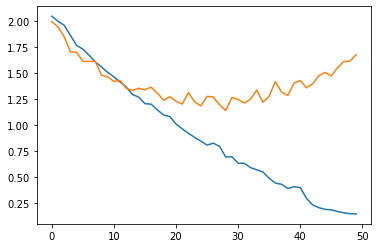

In [15]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

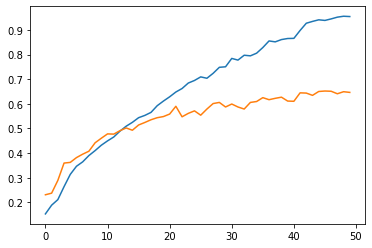

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

In [18]:
# predicting on test data.
pred_test = model.predict(X_test)
y_pred = encoder.inverse_transform(pred_test)

y_test = encoder.inverse_transform(y_test)

In [19]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)

,Predicted Labels,Actual Labels
0,fearful,fearful
1,angry,angry
2,sad,fearful
3,neutral,calm
4,happy,angry
5,surprised,surprised
6,fearful,fearful
7,disgust,happy
8,fearful,fearful
9,surprised,sad


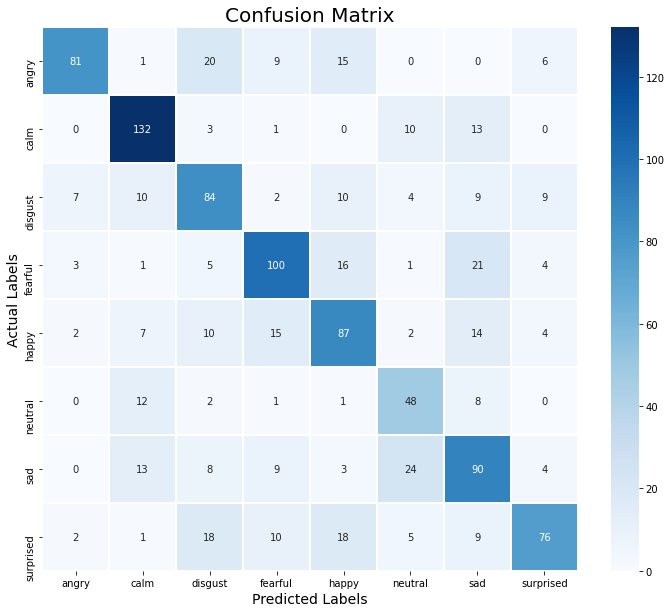

In [20]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 10))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()


In [21]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       angry       0.85      0.61      0.71       132
        calm       0.75      0.83      0.79       159
     disgust       0.56      0.62      0.59       135
     fearful       0.68      0.66      0.67       151
       happy       0.58      0.62      0.60       141
     neutral       0.51      0.67      0.58        72
         sad       0.55      0.60      0.57       151
   surprised       0.74      0.55      0.63       139

    accuracy                           0.65      1080
   macro avg       0.65      0.64      0.64      1080
weighted avg       0.66      0.65      0.65      1080

